# <a id='toc1_'></a>[__Градиентный бустинг над регрессионными деревьями своими руками в задаче прогнозирования стоимости жилья__](#toc0_)

**Содержание**<a id='toc0_'></a>    
- [__Градиентный бустинг над регрессионными деревьями своими руками в задаче прогнозирования стоимости жилья__](#toc1_)    
  - [__Постановка задачи__](#toc1_1_)    
  - [__Импорты и настройки__](#toc1_2_)    
  - [__Обзор данных__](#toc1_3_)    
  - [__Класс *CustomGradientBoostingRegressor*: градиентный бустинг своими руками__](#toc1_4_)    
    - [__Случай постоянного `learning_rate`__](#toc1_4_1_)    
    - [__Случай убывающего `learning_rate`__](#toc1_4_2_)    
  - [__Сравнение с GradientBoostingRegressor__](#toc1_5_)    
    - [__Зависимость ошибки от параметров регрессора__](#toc1_5_1_)    
    - [__Выводы__](#toc1_5_2_)    
  - [__Сравнение с линейной регрессией на тех же данных__](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
## <a id='toc1_1_'></a>[__Постановка задачи__](#toc0_)

Реализуем свой класс для градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь. Проверим корректность своего класса сравнением результатов с аналогичным регрессором из sklearn на общей задаче. Сделаем выводы о влиянии параметров регрессора на качество предсказания в задаче прогнозирования стоимости жилья. 

***
## <a id='toc1_2_'></a>[__Импорты и настройки__](#toc0_)

In [1]:
# стандартная библиотека
from collections.abc import Iterable
from itertools import cycle
from typing import Optional

In [2]:
# сторонние библиотеки
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# глобальные настройки графических библиотек
params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(palette='tab10', style='ticks', rc=params)
matplotlib.rcParams['figure.dpi'] = 400

***
## <a id='toc1_3_'></a>[__Обзор данных__](#toc0_)

In [4]:
boston = pd.read_csv('BostonHousing.csv')
boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [5]:
# для контроля качества оставим последние 25% объектов
X = boston.drop(columns='medv')
y = boston.medv  # median value of owner-occupied homes in $1000s
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

***
## <a id='toc1_4_'></a>[__Класс *CustomGradientBoostingRegressor*: градиентный бустинг своими руками__](#toc0_)

In [6]:
class CustomGradientBoostingRegressor:
    """
    Градиентный бустинг над регрессионными деревьями.
    """
    def __init__(
        self, 
        *, 
        # скорость обучения
        learning_rate: int | float | Iterable[int | float] = 0.1, 
        
        n_estimators: int = 100,  # число деревьев в композиции
        
        max_depth: int = 3,  # максимально допустимая глубина дерева
        
        # стратегия инициализации начального предсказания
        init_strategy: str = 'mean',
        
        # random_state для DecisionTreeRegressor
        random_state: Optional[int] = None
    ) -> None:
        self.trees = []
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.init_strategy = init_strategy
        self.random_state = random_state
    
    @property
    def learning_rate(self):
        return self._learning_rate
    
    @learning_rate.setter
    def learning_rate(self, value):
        if isinstance(value, (int, float)):
            if value < 0:
                raise ValueError("learning_rate must be nonnegative.")
            # циклический итератор из константы по числу деревьев
            self._learning_rate = cycle([value] * self.n_estimators)
        elif hasattr(value, '__iter__'):
            # циклический итератор из коллекции различных значений 
            self._learning_rate = cycle(value)
        self.trees.clear()  # сеттер сбрасывает обученные ранее деревья
    
    @property
    def init_strategy(self):
        return self._init_strategy
    
    @init_strategy.setter
    def init_strategy(self, value):
        if value not in ('mean', 'zero'):
            raise ValueError("init_strategy must be either 'mean' or 'zero'.")
        self._init_strategy = value
        self.trees.clear()  # сеттер сбрасывает обученные ранее деревья
        
    def fit(self, X, y):
        self._init = (  # начальное предсказание
            y.mean() if self._init_strategy == 'mean'
            else 0  # по принципу исключения: не "mean" - значит, "zero"
        )
        combined_predictions = self._init
        for _ in range(self.n_estimators):
            residuals = y - combined_predictions
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                random_state=self.random_state
            )
            
            # следующее дерево обучается на ошибках предыдущего
            prediction = tree.fit(X, residuals).predict(X)
            
            # совместное (кумулятивное) предсказание всех деревьев, 
            # обученных на прошедших итерациях
            combined_predictions += next(self._learning_rate) * prediction
            
            self.trees.append(tree)
        return self
            
    def predict(self, X):
        if not self.trees:
            raise NotFittedError("This regressor is not fitted yet.")
        # каждое обученное дерево делает свой вклад в итоговую сумму
        predictions = [
            next(self._learning_rate) * tree.predict(X) 
            for tree in self.trees
        ]
        return self._init + sum(predictions)

In [7]:
def rmse(regressor) -> float:
    """
    Обучить регрессор и вернуть RMSE на тестовой выборке.
    """
    y_pred = regressor.fit(X_train, y_train).predict(X_test)
    return mean_squared_error(y_test, y_pred, squared=False)

***
### <a id='toc1_4_1_'></a>[__Случай постоянного `learning_rate`__](#toc0_)

In [8]:
reg = CustomGradientBoostingRegressor(
    learning_rate=0.9,
    n_estimators=50,
    max_depth=5,
    random_state=42
)

rmse(reg)

6.360601652693613

In [9]:
reg.init_strategy = 'zero'
rmse(reg)

5.455623403859612

***
### <a id='toc1_4_2_'></a>[__Случай убывающего `learning_rate`__](#toc0_)

In [10]:
reg.learning_rate = 0.9 / (1 + np.arange(50))
rmse(reg)

4.812550945781193

***
## <a id='toc1_5_'></a>[__Сравнение с GradientBoostingRegressor__](#toc0_)

***
### <a id='toc1_5_1_'></a>[__Зависимость ошибки от параметров регрессора__](#toc0_)

In [11]:
def plotter(cls, param: str, values: Iterable[int]) -> None:
    """
    График зависимости RMSE от значений values параметра param 
    регрессора - объекта cls.
    """
    scores = [
        rmse(cls(**{param: value, 'random_state': 42}))
        for value in values
    ]
        
    plt.figure(figsize=(10,4))
    plt.plot(values, scores, lw=2)
    plt.xticks(values, rotation=60)
    plt.xlabel(param)
    plt.ylabel('RMSE')
    plt.title(cls.__name__)
    plt.grid(lw=0.5)
    plt.show()

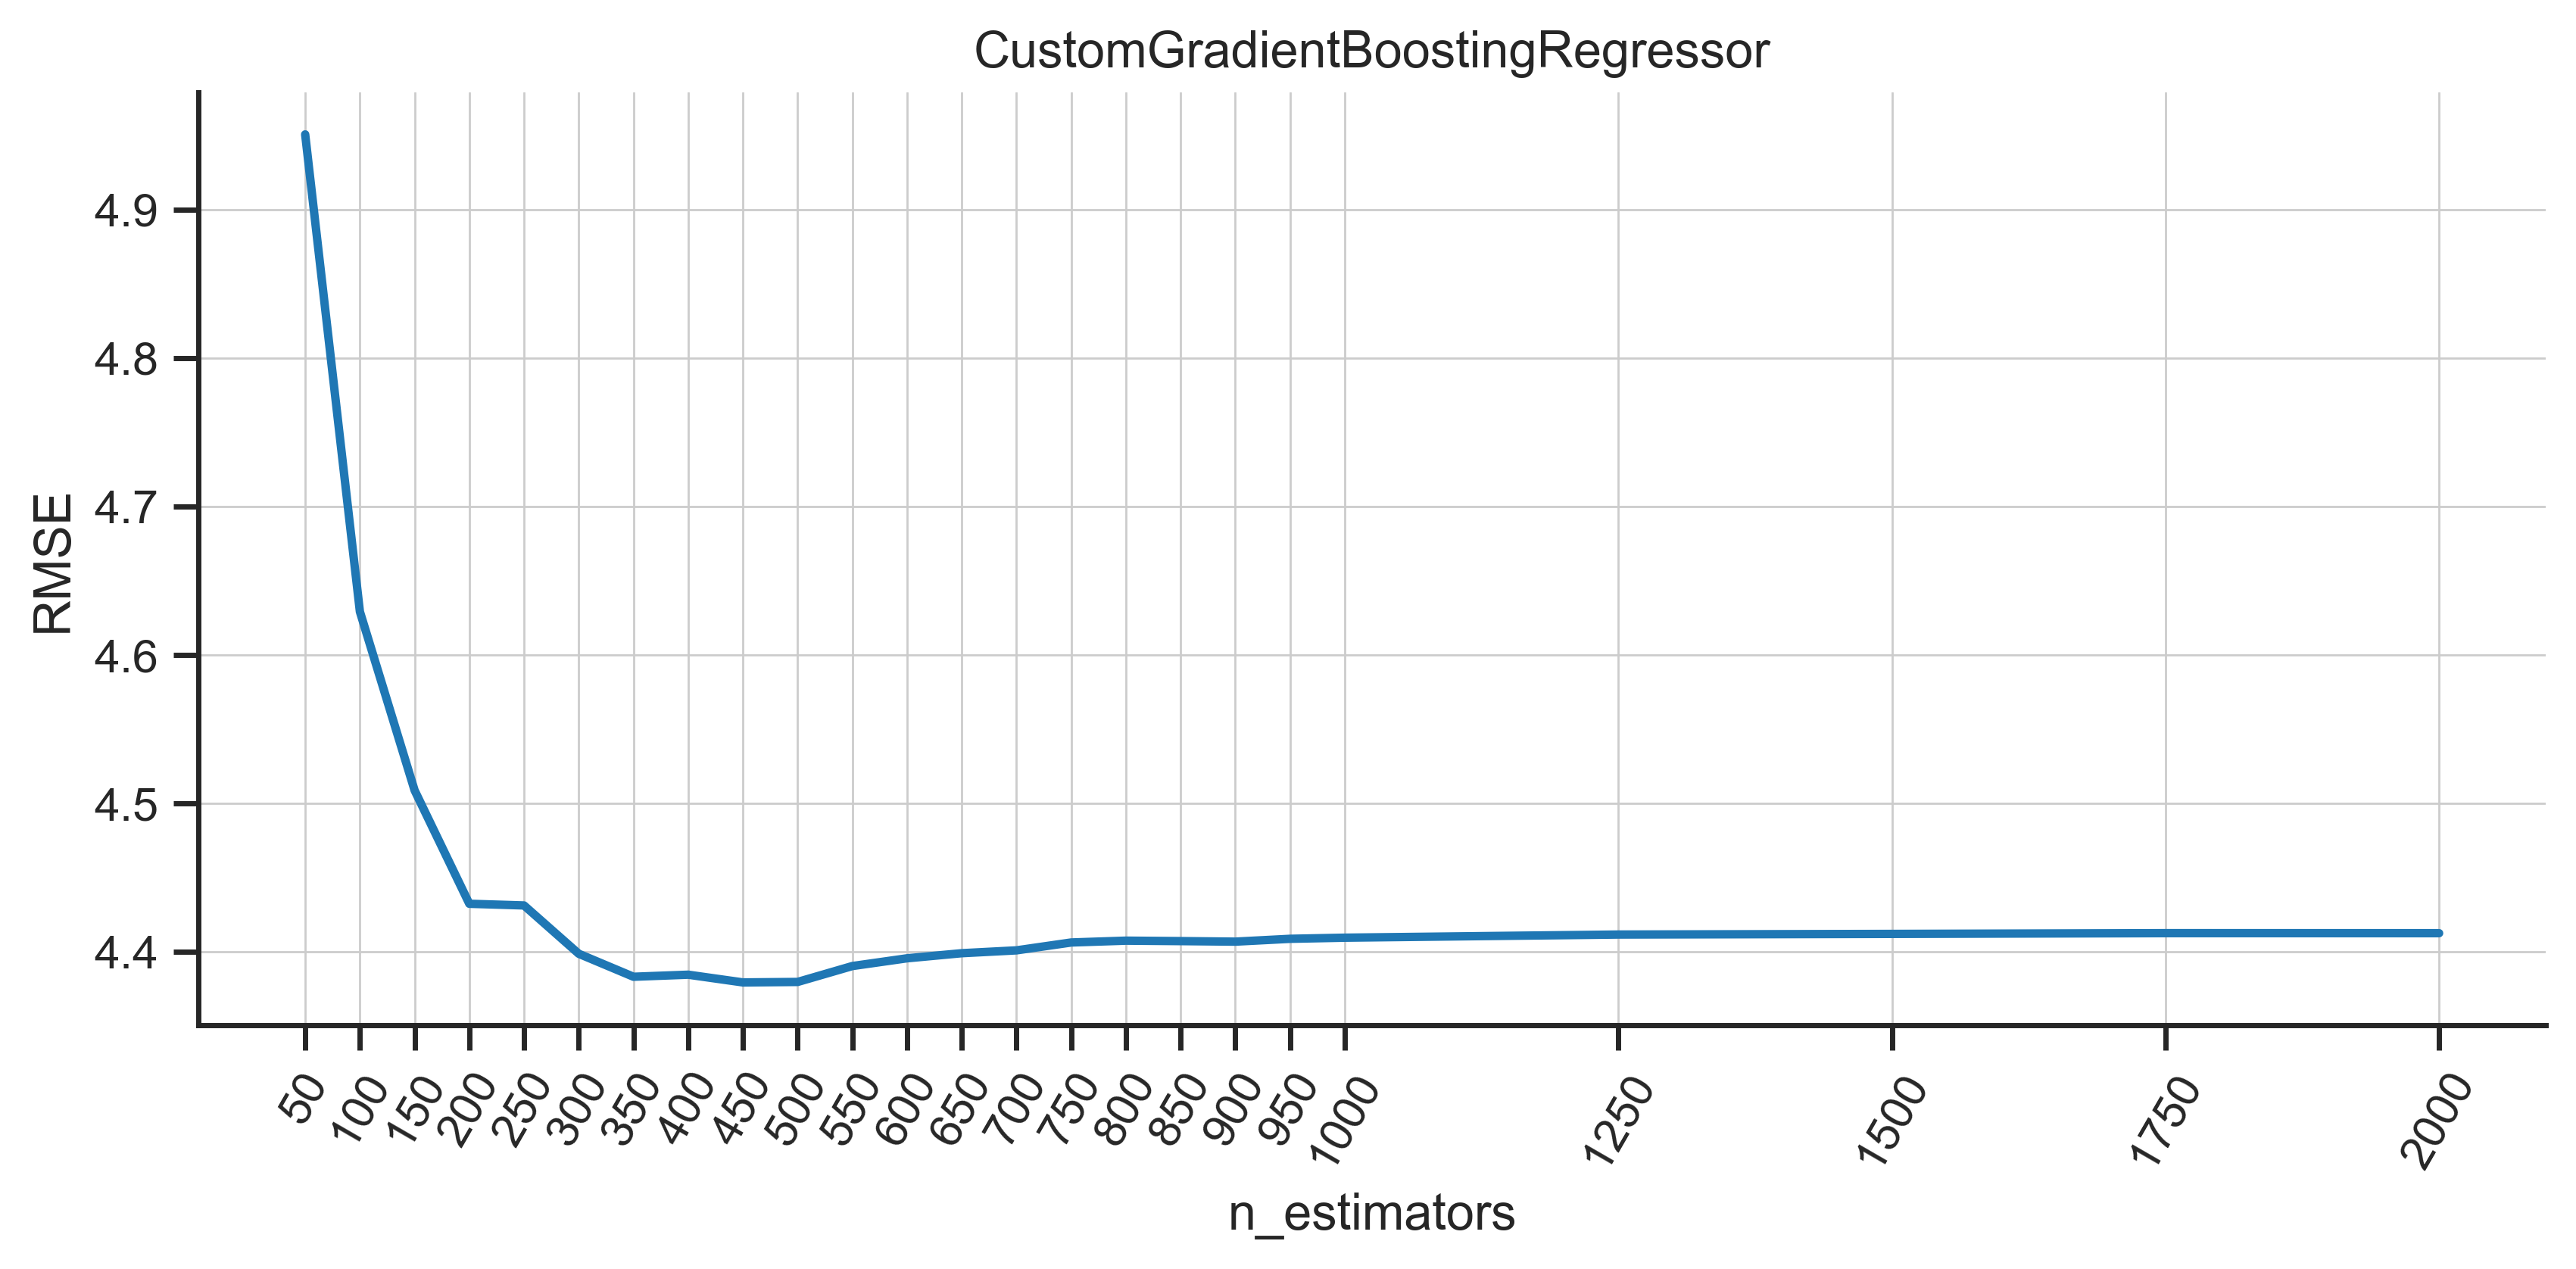

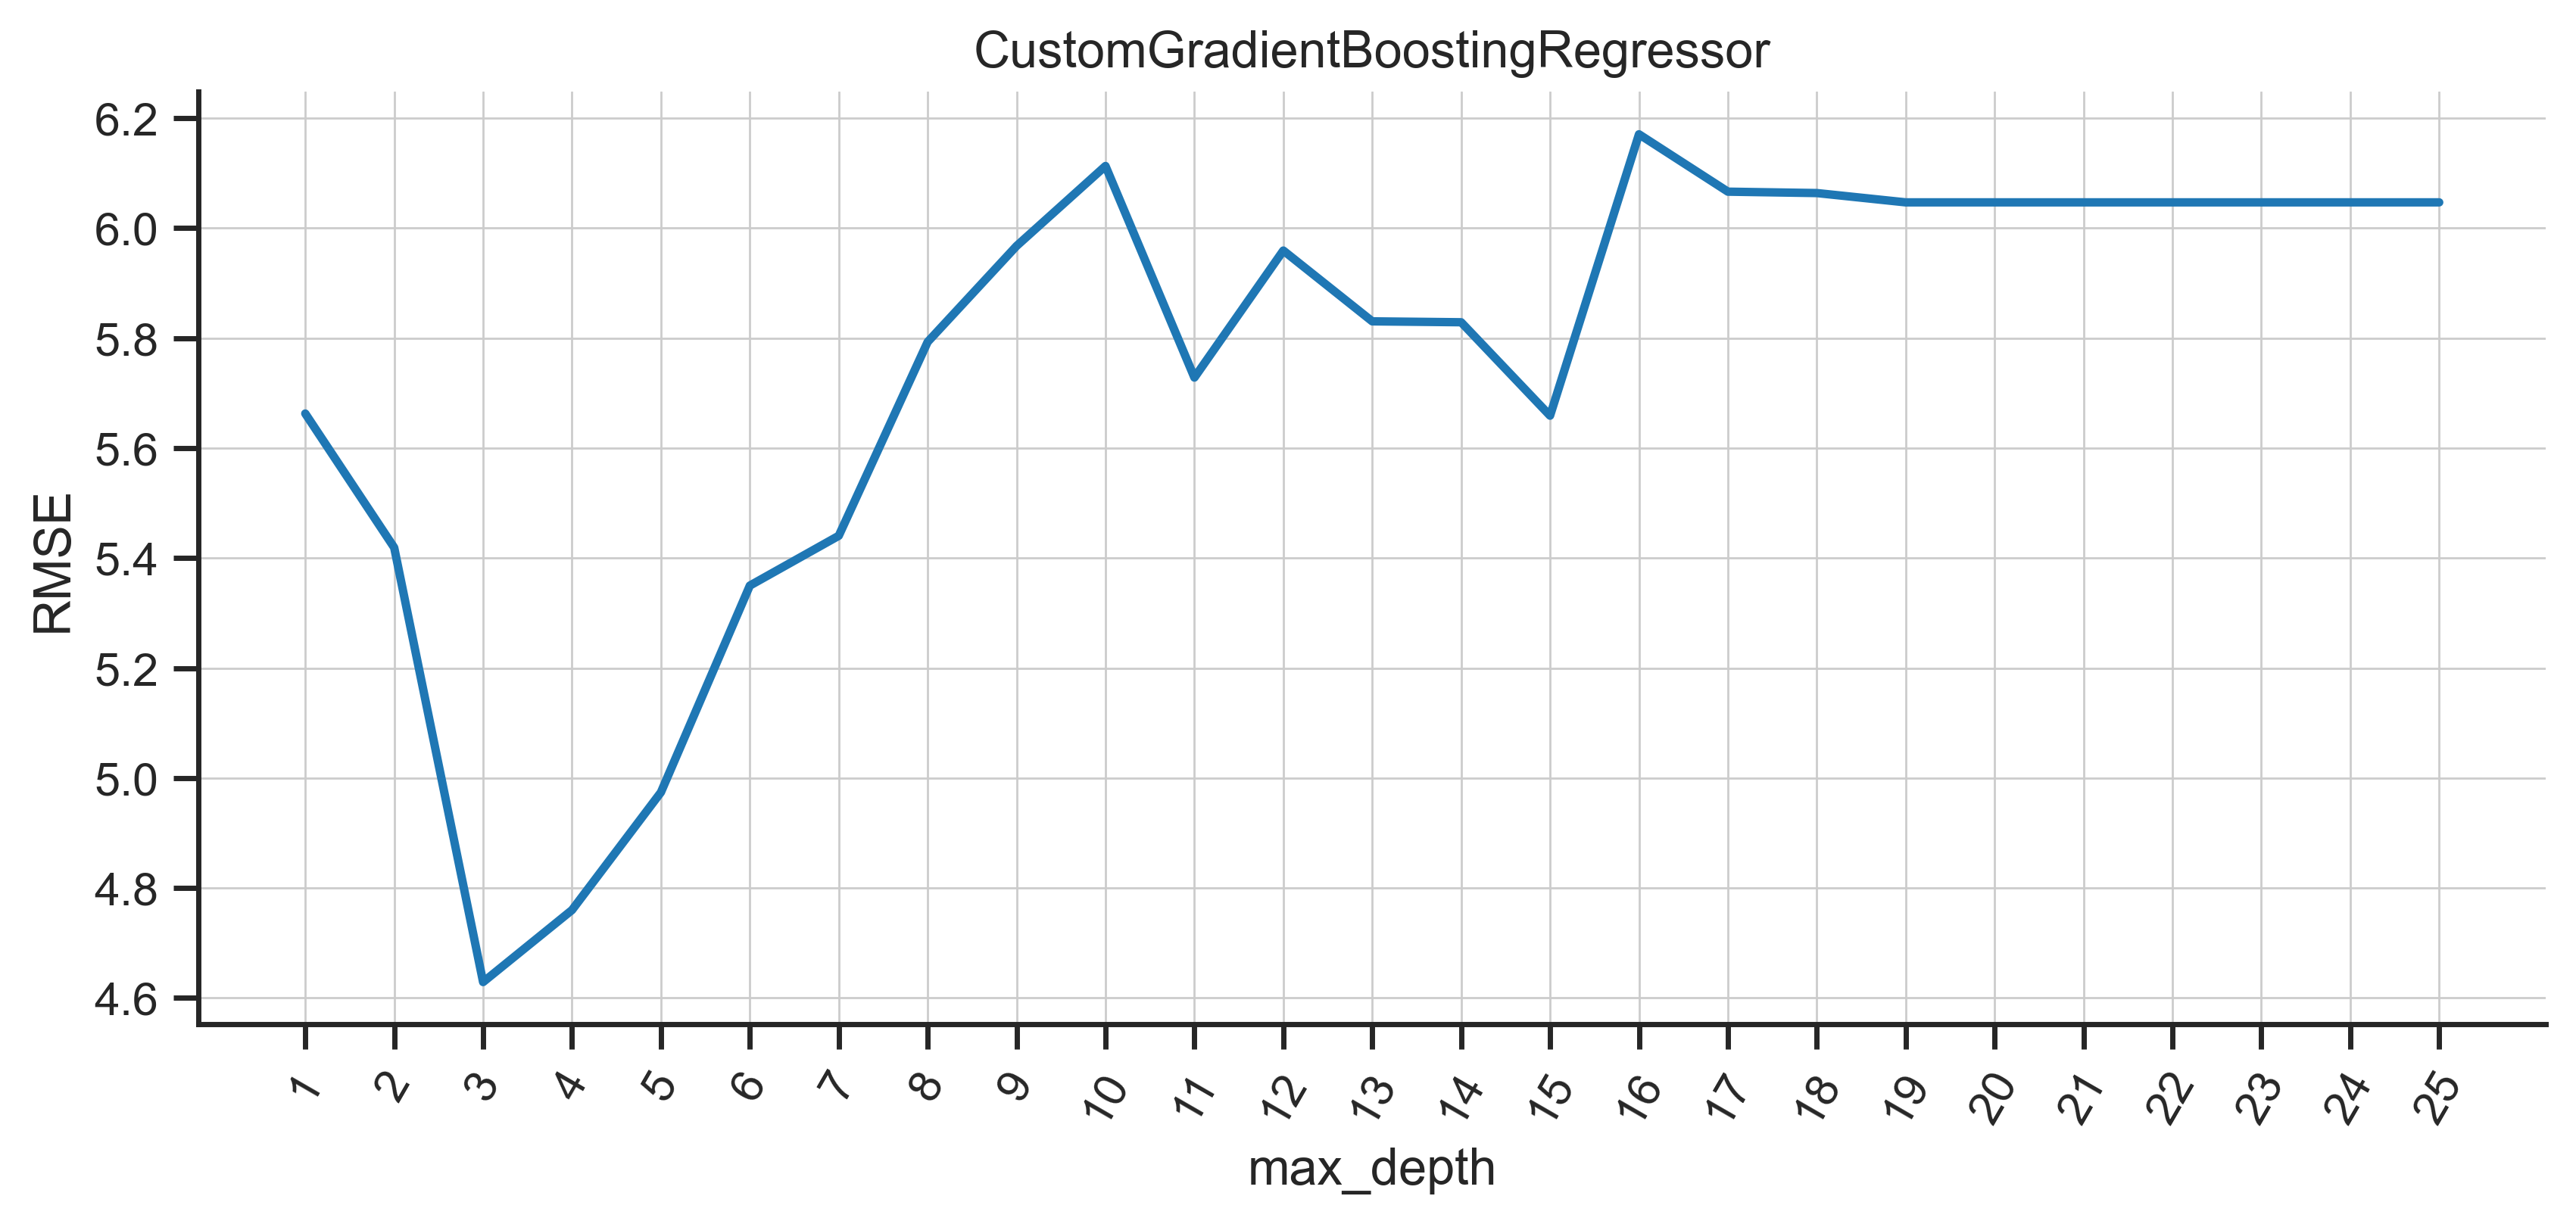

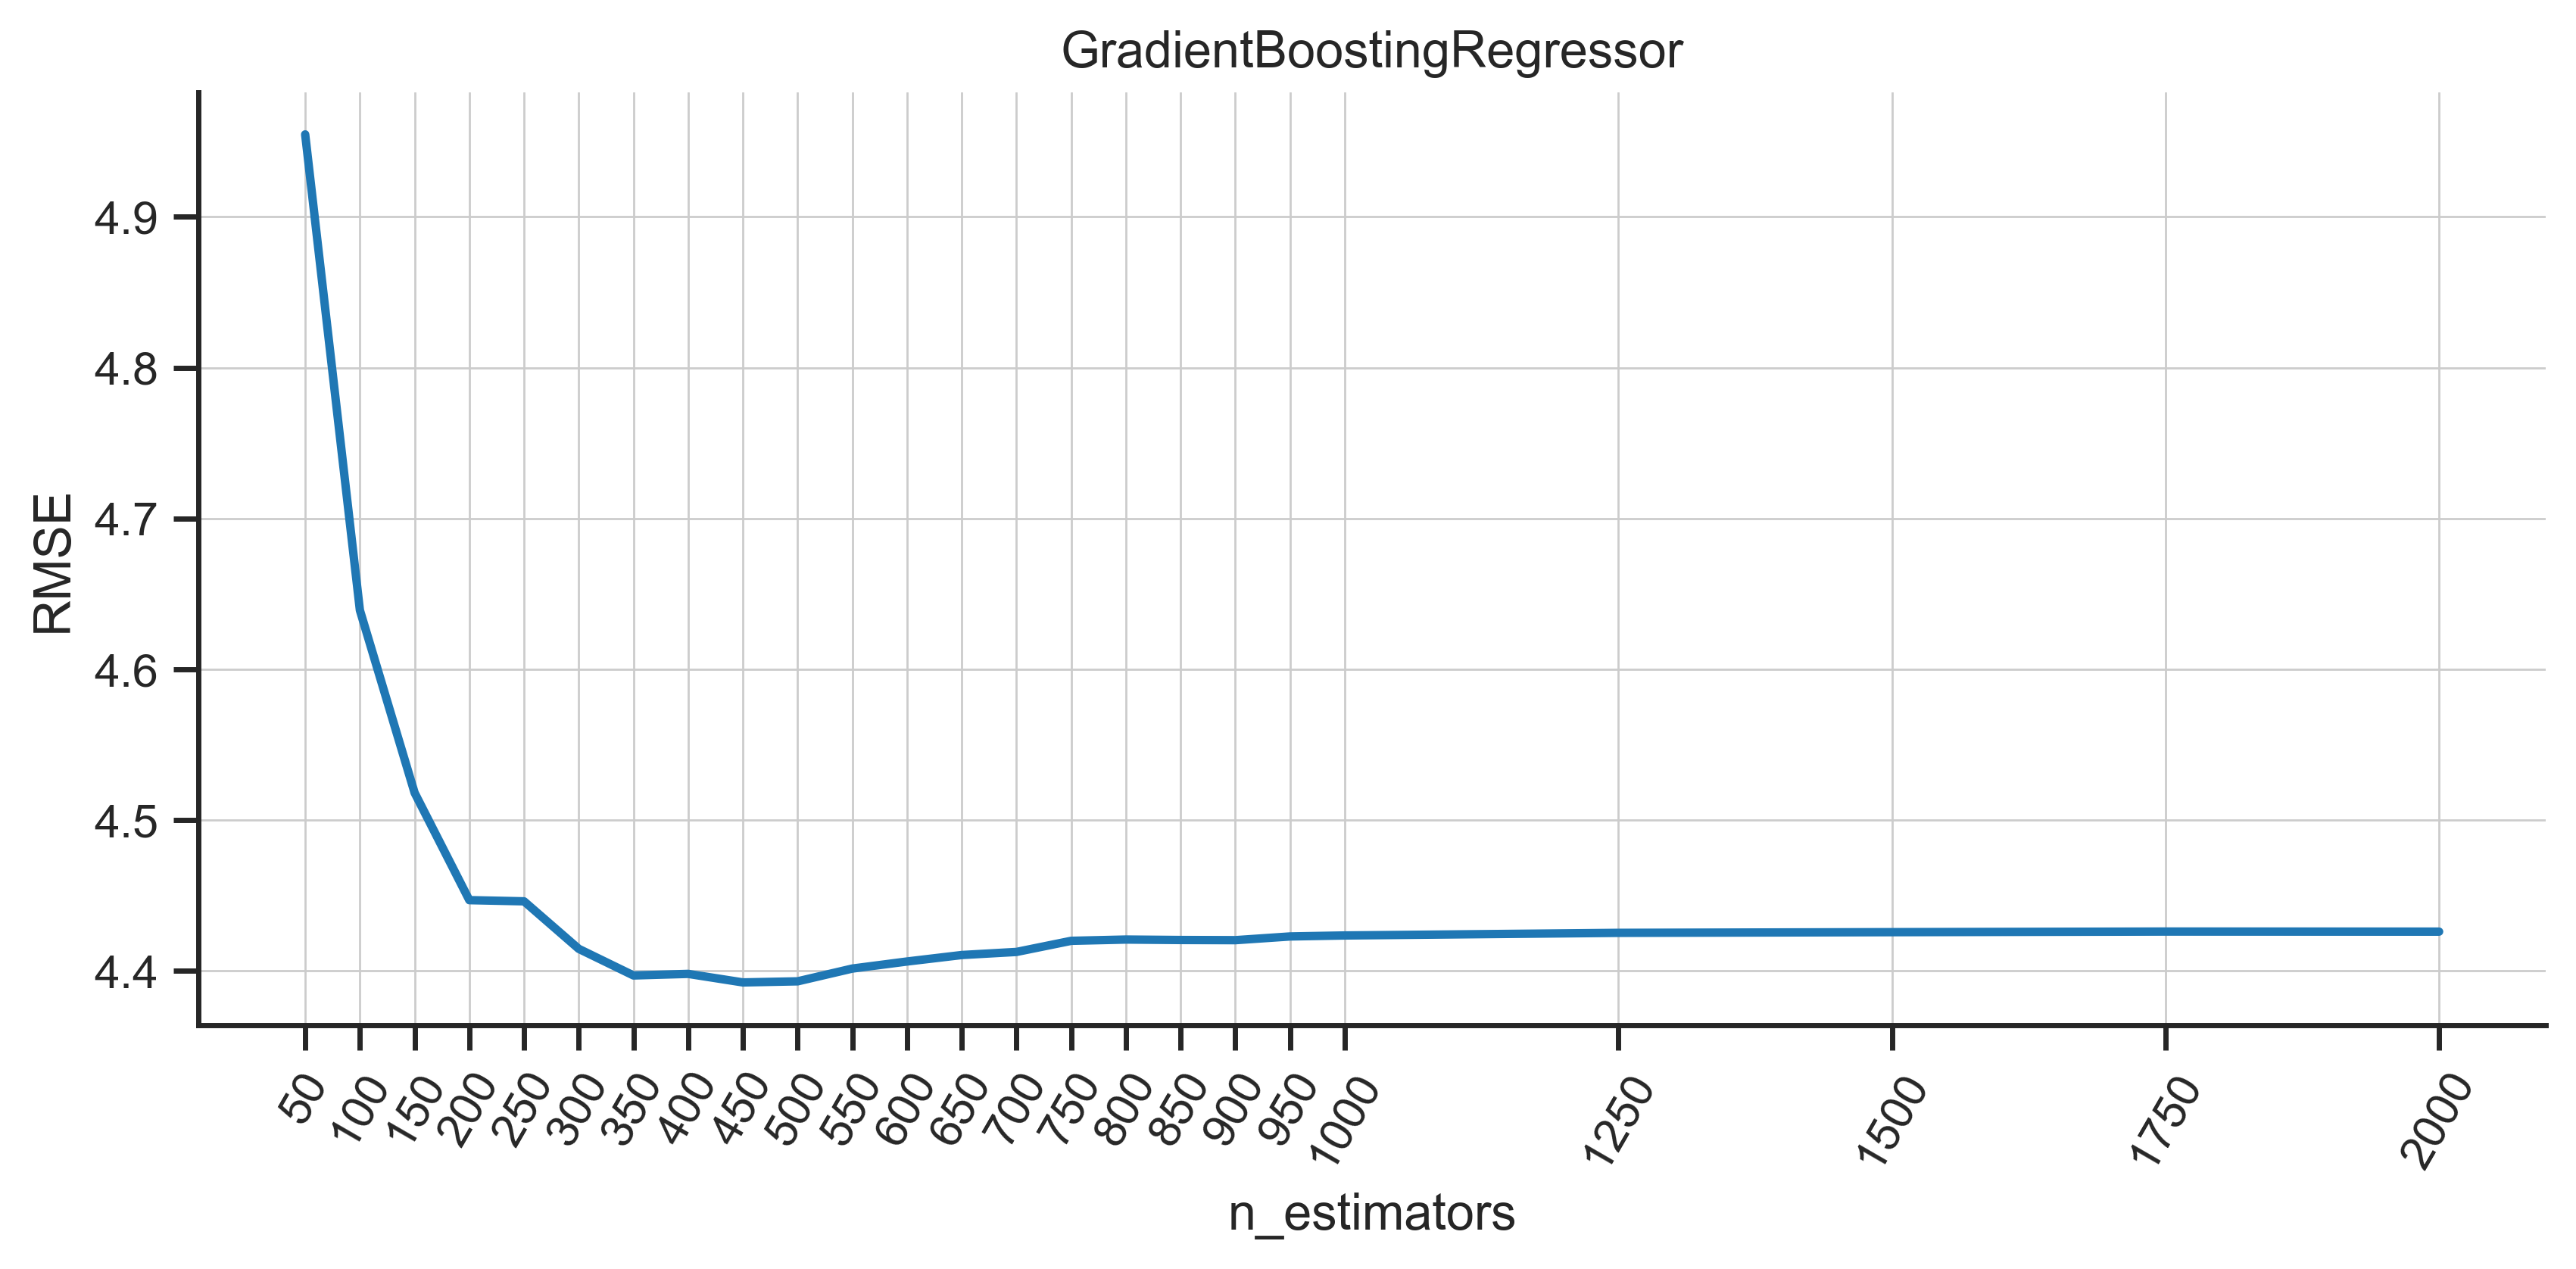

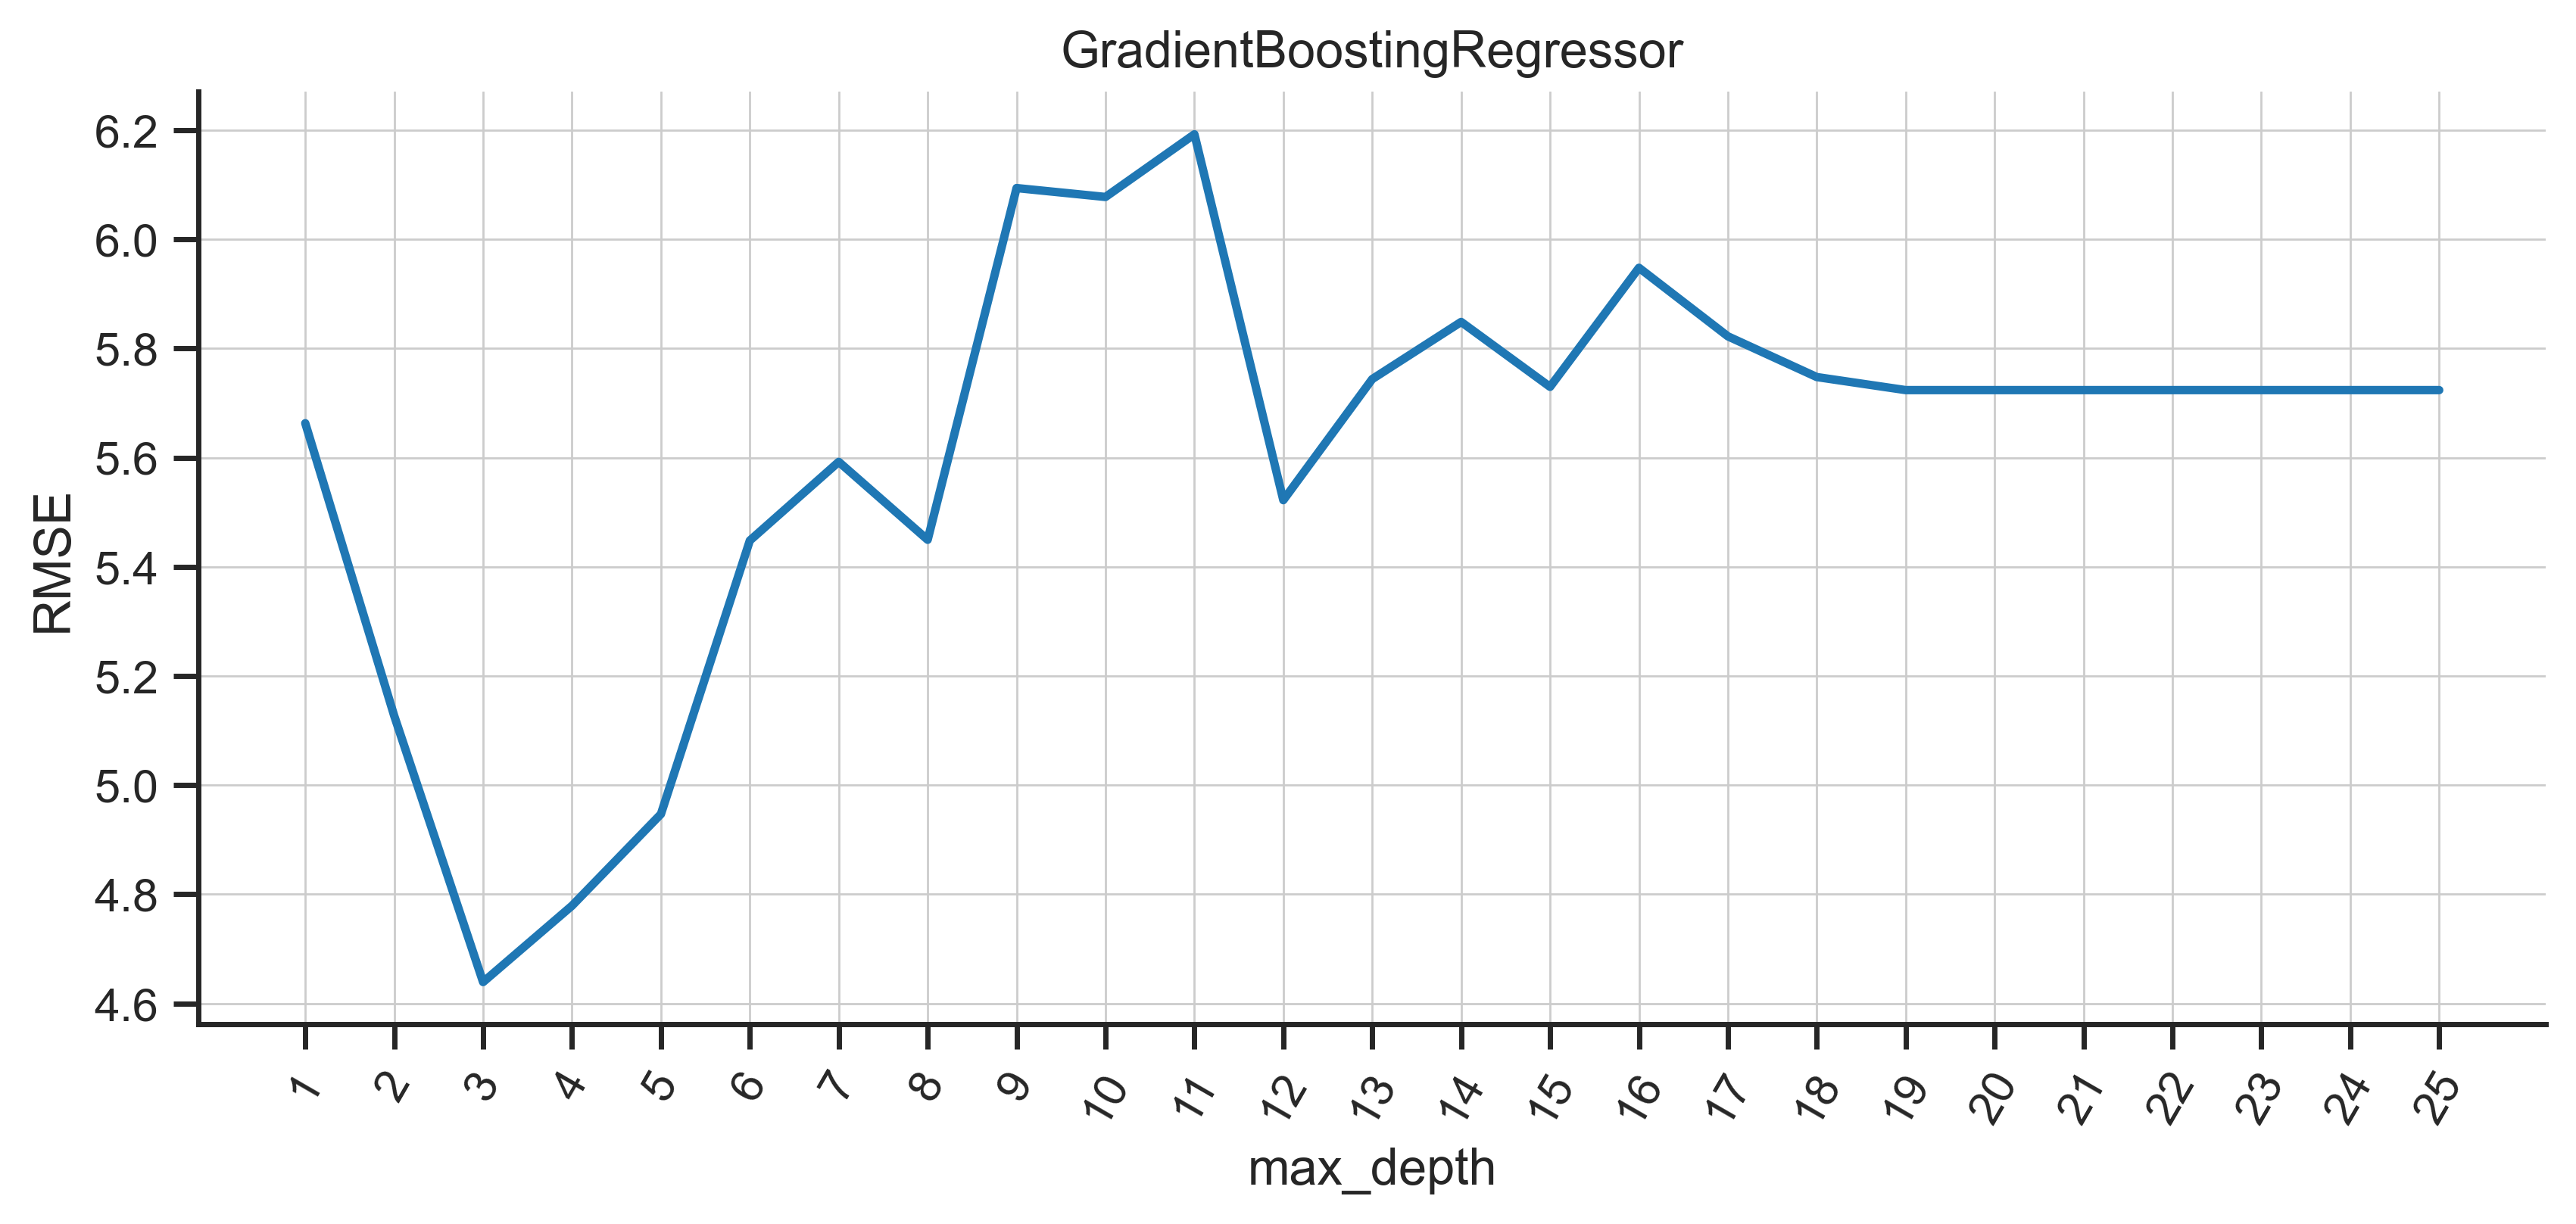

In [12]:
params = {
    'n_estimators': list(range(50, 1050, 50)) + list(range(1250, 2250, 250)),
    'max_depth': range(1, 26)
}

for cls in CustomGradientBoostingRegressor, GradientBoostingRegressor:
    for item in params.items():
        plotter(cls, *item)

***
### <a id='toc1_5_2_'></a>[__Выводы__](#toc0_)

* С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.
* С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

***
## <a id='toc1_6_'></a>[__Сравнение с линейной регрессией на тех же данных__](#toc0_)

In [13]:
rmse(LinearRegression())

8.254979753549211

***